# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import requests
from pprint import pprint

# Import API key
from api_keys import geoapify_key
from citipy import citipy


In [2]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("../output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,gazli,40.1333,63.4500,4.09,50,98,4.83,UZ,1704910353
1,1,grytviken,-54.2811,-36.5092,5.21,96,100,1.54,GS,1704910353
2,2,kyzyl,51.7000,94.4500,-19.43,91,99,0.45,RU,1704910354
3,3,adamstown,-25.0660,-130.1015,24.23,85,42,4.35,PN,1704910354
4,4,papatowai,-46.5619,169.4708,15.02,73,46,2.77,NZ,1704910355


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

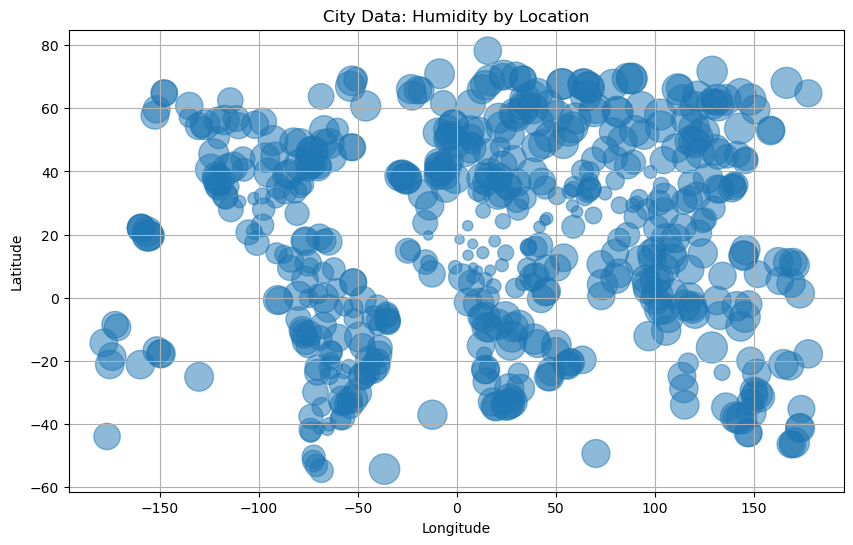

In [3]:
%%capture --no-display

# Configure the map plot
# YOUR CODE HERE
map_plot_1 = city_data_df.hvplot.points(
    'Lng', 
    'Lat', 
    size = 'Humidity',
    geo = True, 
    tiles = 'OSM',
    frame_width = 600, 
    frame_height = 400, 
    color = ['City', 'Humidity']
)

# Display the map
# YOUR CODE HERE
map_plot_1

#import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plotting each city with its humidity as the point size
plt.scatter(city_data_df['Lng'], city_data_df['Lat'], s=city_data_df['Humidity']*5, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Data: Humidity by Location')
plt.grid(True)
plt.show()

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [4]:
# Narrow down cities that fit criteria and drop any results with null values
# YOUR CODE HERE
filtered_cities_df = city_data_df.loc[
    (city_data_df['Humidity'] >= 50) &
    (city_data_df['Max Temp'] > 20) &
    (city_data_df['Wind Speed'] < 4) &
    (city_data_df['Cloudiness'] == 0)
]
# Drop any rows with null values
# YOUR CODE HERE
filtered_cities_df = filtered_cities_df.dropna()

# Display sample data
# YOUR CODE HERE
filtered_cities_df

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
16,16,wailua homesteads,22.0669,-159.3780,21.24,79,0,3.09,US,1704910363
95,95,parkes,-33.1333,148.1833,22.42,73,0,1.71,AU,1704910384
118,118,lihue,21.9789,-159.3672,21.58,79,0,3.09,US,1704910388
150,150,kapa'a,22.0752,-159.3190,21.99,79,0,3.09,US,1704910399


### Step 3: Create a new DataFrame called `hotel_df`.

In [5]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
# YOUR CODE HERE
hotel_df = filtered_cities_df[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
# YOUR CODE HERE
hotel_df['Hotel Name'] = ""

# Display sample data
# YOUR CODE HERE
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel Name
16,wailua homesteads,US,22.0669,-159.3780,79,
95,parkes,AU,-33.1333,148.1833,73,
118,lihue,US,21.9789,-159.3672,79,
150,kapa'a,US,22.0752,-159.3190,79,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [6]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "categories":"accommodation.hotel",
    "apiKey": geoapify_key
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    
    # Get latitude, longitude from the DataFrame
    latitude = row["Lat"]
    longitude = row["Lng"]

    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url,params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
wailua homesteads - nearest hotel: Hilton Garden Inn Kauai Wailua Bay
parkes - nearest hotel: Commercial Hotel
lihue - nearest hotel: Kauai Palms
kapa'a - nearest hotel: Pono Kai Resort


,City,Country,Lat,Lng,Humidity,Hotel Name
16,wailua homesteads,US,22.0669,-159.3780,79,Hilton Garden Inn Kauai Wailua Bay
95,parkes,AU,-33.1333,148.1833,73,Commercial Hotel
118,lihue,US,21.9789,-159.3672,79,Kauai Palms
150,kapa'a,US,22.0752,-159.3190,79,Pono Kai Resort


In [7]:
name_address = requests.get(base_url,params=params)
name_address.url


'https://api.geoapify.com/v2/places?categories=accommodation.hotel&apiKey=17cc2e5dfdae4694ab3ffc8c468acc69&filter=circle%3A-159.319%2C22.0752%2C10000&bias=proximity%3A-159.319%2C22.0752'

### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [8]:
%%capture --no-display

# Configure the map plot
# YOUR CODE HERE
map_plot = hotel_df.hvplot.points(
    'Lng',
    'Lat',
    size='Humidity',
    geo = True,
    tiles='OSM',
    frame_width=600,
    frame_height=400,
    color=['City', 'Humidity'],
    hover_cols=['City','Humidity', 'Hotel Name', 'Country']
 )

# Display the map
map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (Humidity,City,Hotel Name,Country)